Extracting the zip file into a different folder


In [2]:
import zipfile
import os

zip_file_path = '/content/data.zip'

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset_folder')


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [4]:
labelsDF = pd.read_csv('/content/dataset_folder/label.csv')
print(labelsDF.head())

      filename         label
0  Image_1.jpg       sitting
1  Image_2.jpg  using_laptop
2  Image_3.jpg       hugging
3  Image_4.jpg      sleeping
4  Image_5.jpg  using_laptop


**part a. 1.**

*Number of images per class:*

In [5]:
from PIL import Image #trying the image processing library in python
import matplotlib.pyplot as plt

# img = Image.open('/content/dataset_folder/data/Image_1.jpg')

# # Displaying the image
# plt.imshow(img)
# plt.axis('off')  # Hide axes
# plt.show()

# print("\n-------#--#--#-------\na")

# # Counting the number of images per class
# class_distribution = labelsDF['label'].value_counts()
# print("Number of images per class:\n\n", class_distribution)

# print("\n-------#--#--#-------\n")

*Image size and aspect ratio analysis*


In [6]:
image_folder = '/content/dataset_folder/data'
image_sizes = []

# Looping thru images and getting their sizes
for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    with Image.open(img_path) as img:
        width, height = img.size
        image_sizes.append((width, height))

print("\n-------#--#--#-------\n")

# Converting to pandas DataFrame to analyze distribution
sizesDF = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
print("Image size analysis: \n\n", sizesDF.describe())  # Getting basic stats on image sizes

print("\n-------#--#--#-------\n")

# Aspect Ratio (width / height) for each image
sizesDF['Aspect_Ratio'] = sizesDF['Width'] / sizesDF['Height']
print("Aspect ratio distribution: \n\n", sizesDF['Aspect_Ratio'].describe())

print("\n-------#--#--#-------\n")

*File size information:*

In [ ]:
file_sizes = []

# Geting file size in kilobytes
for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)
    file_size = os.path.getsize(img_path) / 1024  # Converting to KB
    file_sizes.append(file_size)

print("\n-------#--#--#-------\n")

# the file size distribution
file_sizes_df = pd.DataFrame(file_sizes, columns=['File_Size_KB'])
print("File size information: \n\n",file_sizes_df.describe())

print("\n-------#--#--#-------\n")



-------#--#--#-------

File size information: 

        File_Size_KB
count  12601.000000
mean      17.778715
std        5.691770
min        3.617188
25%       13.585938
50%       17.015625
75%       21.316406
max       44.138672

-------#--#--#-------



**part a. 2.**

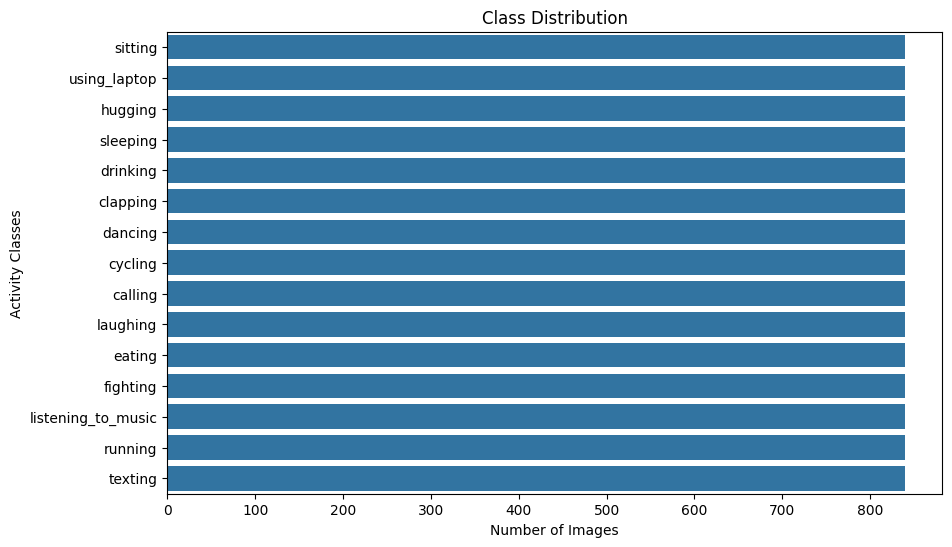

In [ ]:
# Bar plot for class distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=labelsDF['label'], order=labelsDF['label'].value_counts().index)
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Activity Classes')
plt.show()

In [7]:

def plotSampleImagesPerClass(imageFolder, labelsDf, numSamples=3):

    # Getting the unique classes for every image type
    activityClasses = labelsDf['label'].unique()

    for idx, className in enumerate(activityClasses):
        plt.figure(figsize=(20, 75))

        # Selecing a few sample images for the current class
        sampleImages = labelsDf[labelsDf['label'] == className].sample(numSamples)['filename']

        print(className)

        for i, imgName in enumerate(sampleImages):
            imgPath = os.path.join(imageFolder, imgName)
            img = Image.open(imgPath)

            # Showing the image
            plt.subplot(len(activityClasses), numSamples, idx * numSamples + i + 1)
            plt.imshow(img)
            plt.axis('off')


        plt.tight_layout()
        plt.show()

#ploting sample images from each class
plotSampleImagesPerClass(imageFolder='/content/dataset_folder/data', labelsDf=labelsDF, numSamples=3)

# !pip install mahotas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.6 MB/s eta 0:00:00


**part 2.**

In [31]:
import cv2
import numpy as np
import mahotas
from skimage.feature import hog, canny, local_binary_pattern
from skimage import color, io
from skimage.feature import graycomatrix, graycoprops
from skimage.filters import gabor
from sklearn.cluster import KMeans
from skimage.feature import local_binary_pattern

imageFolder='/content/dataset_folder/data'

In [32]:
# CSV file containing image paths and ---->>>>> labelsDF

# function to load and preprocess images for consistency
def load_and_preprocess_image(image_path, target_size=(64, 64)):
    image = io.imread(image_path)
    image_resized = cv2.resize(image, target_size)
    return image_resized

In [33]:
pixels_per_cell=(16, 16)
cells_per_block=(4, 4)
orientations=9

from joblib import Parallel, delayed

def extract_features(image_path, label):
    # Load and preprocess image
    image = load_and_preprocess_image(image_path)

    # Convert the image to grayscale
    gray_image = color.rgb2gray(image)

    # HOG features
    hog_features = hog(
        gray_image,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        block_norm='L2-Hys',
        visualize=False
    )

    # Extract histogram features for each channel
    hist_features = []
    for i in range(image.shape[-1]):
        hist, _ = np.histogram(image[:, :, i], bins=16, range=(0, 256))  # Reduced bins
        hist_features.extend(hist)

    # Normalize the histogram
    hist_features = np.array(hist_features) / np.sum(hist_features)

    # Convert image to HSV and extract histograms for HSV channels
    hsv_image = color.rgb2hsv(image)
    hsv_hist_features = []
    for i in range(hsv_image.shape[-1]):
        hist, _ = np.histogram(hsv_image[:, :, i], bins=16, range=(0, 1))  # HSV range is 0-1
        hsv_hist_features.extend(hist)

    # Normalize HSV histogram
    hsv_hist_features = np.array(hsv_hist_features) / np.sum(hsv_hist_features)

    # Convert image to Lab and extract histograms for Lab channels
    lab_image = color.rgb2lab(image)
    lab_hist_features = []
    for i in range(lab_image.shape[-1]):
        hist, _ = np.histogram(lab_image[:, :, i], bins=16, range=(-100, 100))  # Lab range
        lab_hist_features.extend(hist)

    # Normalize Lab histogram
    lab_hist_features = np.array(lab_hist_features) / np.sum(lab_hist_features)

    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    haralick_features = mahotas.features.haralick(gray_image, distance=1).mean(axis=0)

    distances=[1]
    angles=[0]
    glcm = graycomatrix(gray_image, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Extract various features from GLCM
    contrast = graycoprops(glcm, 'contrast').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()

    # Combine all GLCM features into a single array
    glcm_features = np.hstack([contrast, correlation, energy, homogeneity])

    edges = cv2.Canny(image, threshold1=100, threshold2=200)
    edge_density = np.sum(edges) / edges.size

    # kmeans = KMeans(n_clusters=5)
    # dominant_colors = (kmeans.fit(image.reshape(-1, 3)).cluster_centers_).flatten()

    # lbp_features = []
    # lbp = local_binary_pattern(gray_image, P=8, R=1, method='uniform')
    # lbp_features.append(np.histogram(lbp, bins=np.arange(0, 11), density=True)[0])
    # lbp_features = np.array(lbp_features).flatten()


    # Combine features (HOG, RGB, HSV, Lab)
    combined_features = np.hstack([hog_features, hist_features, hsv_hist_features, lab_hist_features, haralick_features, glcm_features, edge_density])


    return combined_features, label

# Use parallel processing to extract features from all images
features_labels = Parallel(n_jobs=-1)(delayed(extract_features)(
    os.path.join(imageFolder, row['filename']), row['label'])
    for _, row in labelsDF.iterrows())

# Unpack features and labels
X, y = zip(*features_labels)
X = np.array(X)
y = np.array(y)

In [34]:
# Now print the dimensionality of the extracted features
num_images = X.shape[0]
feature_dimensionality = X.shape[1]

print(num_images)
print(feature_dimensionality)

# pixels_per_cell=(16, 16)
# cells_per_block=(4, 4)
# orientations=9

# # Assuming HOG features are first in combined_features
# # Load a sample image and convert it to grayscale
# sample_image = load_and_preprocess_image(os.path.join(imageFolder, labelsDF.iloc[0]['filename']))
# gray_image = color.rgb2gray(sample_image)

# # Compute HOG features for the sample image
# hog_features = hog(
#     gray_image,
#     orientations=orientations,
#     pixels_per_cell=pixels_per_cell,
#     cells_per_block=cells_per_block,
#     block_norm='L2-Hys',
#     visualize=False
# )

# # HOG features dimension for the sample image
# hog_feature_dim = len(hog_features)

# print(f"HOG Feature Dimension: {hog_feature_dim}")
# print(f"RGB Histogram Feature Dimension: {48}")  # Since 16 bins per channel and 3 channels
# print(f"HSV Histogram Feature Dimension: {48}")  # Same as above for HSV
# print(f"Lab Histogram Feature Dimension: {48}")  # Same as above for Lab

# # Print total dimensionality
print(f"Combined Feature Vector Dimensionality: {hog_feature_dim + 48 + 48 + 48}")

12600
306
Combined Feature Vector Dimensionality: 288


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.feature_selection import RFE

import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

# Shuffle the features and labels together
X, y = shuffle(X, y, random_state=42)

# Assuming 'X' contains your extracted features (HOG, color histogram, etc.)
# And 'y' contains the corresponding categorical labels

# Encode the target labels (categorical) into numerical values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [48]:


# Create LightGBM Dataset objects
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters for LightGBM
params = {
    'objective': 'multiclass',    # For multiclass classification
    'num_class': len(set(y)),     # Set this to the number of target classes
    'metric': 'multi_logloss',    # Loss function for multiclass classification
    'boosting_type': 'gbdt',      # Gradient Boosting Decision Tree
    'learning_rate': 0.05,        # Step size shrinkage to prevent overfitting
    'num_leaves': 31,             # Controls the complexity of the model
    'max_depth': -1,              # No maximum depth, can grow trees as deep as necessary
    'min_data_in_leaf': 20,       # Minimum number of records per leaf
    'feature_fraction': 0.8,      # Feature selection ratio (boosting on 80% of features)
    'bagging_fraction': 0.8,      # Bagging fraction for each iteration (boosting on 80% of data)
    'bagging_freq': 5,            # Perform bagging every 5 iterations
}

# Train the LightGBM model
lgb_model = lgb.train(params, train_data, num_boost_round=800, valid_sets=[train_data, test_data])

# Predict on the test set
y_pred = lgb_model.predict(X_test)
y_pred_labels = [list(x).index(max(x)) for x in y_pred]  # Convert probabilities to predicted class labels

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'LightGBM Model Accuracy: {accuracy * 100:.2f}%')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 73156
[LightGBM] [Info] Number of data points in the train set: 10080, number of used features: 295
[LightGBM] [Info] Start training from score -2.711031
[LightGBM] [Info] Start training from score -2.732148
[LightGBM] [Info] Start training from score -2.700637
[LightGBM] [Info] Start training from score -2.741336
[LightGBM] [Info] Start training from score -2.685974
[LightGBM] [Info] Start training from score -2.680169
[LightGBM] [Info] Start training from score -2.694746
[LightGBM] [Info] Start training from score -2.733673
[LightGBM] [Info] Start training from score -2.685974
[LightGBM] [Info] Start training from score -2.690351
[LightGBM] [Info] Start training from score -2.675837
[LightGBM] [Info] Start training from score -2.7352

In [ ]:
rf = RandomForestClassifier(
    n_estimators=465,
    max_depth=20,  # 20
    min_samples_split=10, #10
    # min_samples_leaf=5,
    max_features='sqrt',
    bootstrap=False,
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred1 = rf.predict(X_train)
accuracy1 = accuracy_score(y_train, y_pred1)

print(f"Training Accuracy on RF: {accuracy1:.4f}")

print(f"Testing Accuracy on R: {accuracy_score(y_test, y_pred):.4f}")

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
 
nb = GaussianNB()
 
nb.fit(X_train, y_train)
 
y_pred_nb = nb.predict(X_test)
y_pred_nb_train = nb.predict(X_train)
 
accuracy_nb_train = accuracy_score(y_train, y_pred_nb_train)
accuracy_nb_test = accuracy_score(y_test, y_pred_nb)

print(f"Training Accuracy on Naive Bayes: {accuracy_nb_train:.4f}")
print(f"Testing Accuracy on Naive Bayes: {accuracy_nb_test:.4f}")


Training Accuracy on Naive Bayes: 0.1817
Testing Accuracy on Naive Bayes: 0.1837


In [ ]:
from sklearn.tree import DecisionTreeClassifier
 
dt = DecisionTreeClassifier(
    max_depth=20,
    min_samples_split=15,
    random_state=42
) 

dt.fit(X_train, y_train)
 
y_pred_dt = dt.predict(X_test)
y_pred_dt_train = dt.predict(X_train)
 
accuracy_dt_train = accuracy_score(y_train, y_pred_dt_train)
accuracy_dt_test = accuracy_score(y_test, y_pred_dt)

print(f"Training Accuracy on Decision Tree: {accuracy_dt_train:.4f}")
print(f"Testing Accuracy on Decision Tree: {accuracy_dt_test:.4f}")


Training Accuracy on Decision Tree: 0.6461
Testing Accuracy on Decision Tree: 0.1742


In [ ]:
from sklearn.linear_model import Perceptron
 
perceptron = Perceptron(max_iter=1000, random_state=42)
 
perceptron.fit(X_train, y_train)
 
y_pred_perceptron = perceptron.predict(X_test)
y_pred_perceptron_train = perceptron.predict(X_train)
 
accuracy_perceptron_train = accuracy_score(y_train, y_pred_perceptron_train)
accuracy_perceptron_test = accuracy_score(y_test, y_pred_perceptron)

print(f"Training Accuracy on Perceptron: {accuracy_perceptron_train:.4f}")
print(f"Testing Accuracy on Perceptron: {accuracy_perceptron_test:.4f}")

Training Accuracy on Perceptron: 0.0888
Testing Accuracy on Perceptron: 0.0917


saving the model

In [49]:
import pickle

model_filename = 'lgb_model_41.71.pkl'

# Open a file where you want to store the model and save it
with open(model_filename, 'wb') as file:
    pickle.dump(lgb_model, file)  # Saving the model

In [50]:
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Use the loaded model to predict or evaluate
y_pred = loaded_model.predict(X_test)
y_pred = [list(x).index(max(x)) for x in y_pred] #for lightboosted model

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy from loaded model: {accuracy:.4f}")

Test accuracy from loaded model: 0.4171
